# Week-11 MLS: Finsights Grey - RAG for Effective Information Retrieval

# 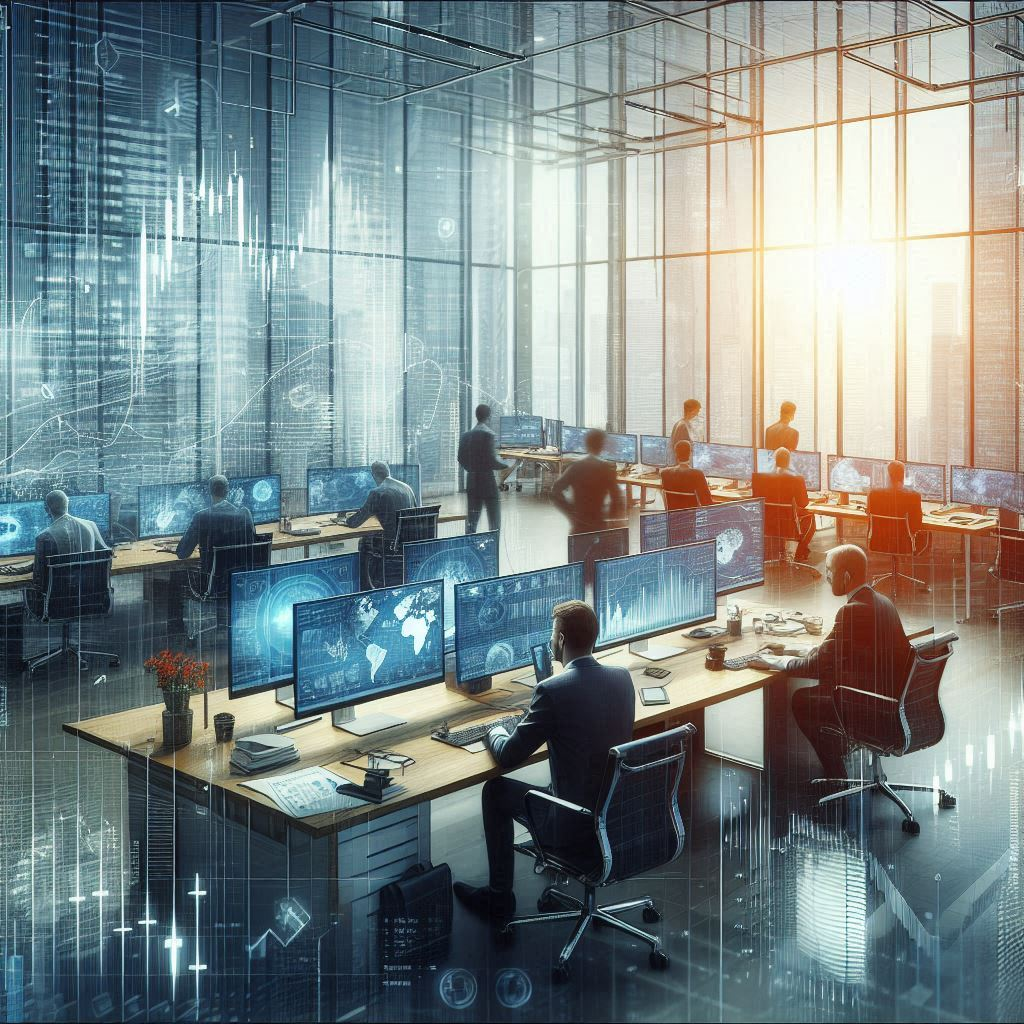


## Business Use Case

**Problem Statement:**

Finsights Grey Inc. is an innovative financial technology firm that specializes in providing advanced analytics and insights for investment management and financial planning. The company handles an extensive collection of 10-K reports from various industry players, which contain detailed information about financial performance, risk factors, market trends, and strategic initiatives. Despite the richness of these documents, Finsights Grey's financial analysts struggle with extracting actionable insights efficiently in a short span due to the manual and labor-intensive nature of the analysis. Going through the document to find the exact information needed at the moment takes too long. This bottleneck hampers the company's ability to deliver timely and accurate recommendations to its clients. To overcome these challenges, Finsights Grey Inc. aims to implement a Retrieval-Augmented Generation (RAG) model to automate the extraction, summarization, and analysis of information from the 10-K reports, thereby enhancing the accuracy and speed of their investment insights.

**Objective:**

As a Gen AI Data Scientist hired by Finsights Grey Inc., the objective is to develop an advanced RAG-based system to streamline the extraction and analysis of key information from 10-K reports.

The project will involve testing the RAG system on a current business problem. The Financial analysts are asked to research major cloud and AI platforms such as Amazon AWS, Google Cloud, Microsoft Azure, Meta AI, and IBM Watson to determine the most effective platform for this application. The primary goals include improving the efficiency of data extraction. Once the project is deployed, the system will be tested by a financial analyst with the following questions. Accurate text retrieval for these questions will imply the project's success.

**Questions:**

1. Has the company made any significant acquisitions in the AI space, and how are these acquisitions being integrated into the company's strategy?

2. How much capital has been allocated towards AI research and development?

3. What initiatives has the company implemented to address ethical concerns surrounding AI, such as fairness, accountability, and privacy?

4. How does the company plan to differentiate itself in the AI space relative to competitors?

Each Question must be asked for each of the five companies.

By successfully developing this project, we aim to:

Improve the productivity of financial analysts by providing a competent tool.

Provide timely insights to improve client recommendations.

Strengthen FinTech Insights Inc.’s competitive edge by delivering more reliable and faster insights to clients.


**Connect to a T4 GPU Instance to create the Vector Database.**

### Setup

In [1]:
!pip install -q openai==1.23.2 \
                tiktoken==0.6.0 \
                pypdf==4.0.1 \
                langchain==0.1.1 \
                langchain-community==0.0.13 \
                chromadb==0.4.22 \
                sentence-transformers==2.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.4/802.4 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 7.3 MB/s et

In [2]:
# Import the necessary Libraries
import json

import pandas as pd

from openai import AzureOpenAI

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFDirectoryLoader

from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings
)
from langchain_community.vectorstores import Chroma

from google.colab import userdata, drive

## Impementing RAG

## Prepare Data

Let's start by loading the dataset.

In [3]:
#Upload Dataset-10k.zip and unzip it dataset folder using -d option
!unzip Dataset-10k.zip -d dataset

Archive:  Dataset-10k.zip
  inflating: dataset/IBM-10-k-2023.pdf  
  inflating: dataset/Meta-10-k-2023.pdf  
  inflating: dataset/aws-10-k-2023.pdf  
  inflating: dataset/google-10-k-2023.pdf  
  inflating: dataset/msft-10-k-2023.pdf  


### Chunking

In [4]:
# Provide pdf_folder_location
pdf_folder_location = "dataset"

In [5]:
# Load the directory to pdf_loader
pdf_loader = PyPDFDirectoryLoader(pdf_folder_location)

Let's split the contents of the pdf into chunks of size 512 (as this is the max size allowed by the embedding model we have choosen. Leet's also have some overlap between the chunks. 16 token should give us 2 sentences of overlap.

In [6]:
# Create text_splitter
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    encoding_name='cl100k_base',
    chunk_size=512,
    chunk_overlap=16
)

In [7]:
# Create chunks
report_chunks = pdf_loader.load_and_split(text_splitter)

/usr/local/lib/python3.10/dist-packages/pypdf/_crypt_providers/_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from this module in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


In [8]:
# Check the total number of chunks
len(report_chunks)

908

In [9]:
# Check the first object in report_chunks and print it
report_chunks[0]

Document(page_content='Table of Contents\nUNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549\n ____________________________________\nFORM 10-K\n____________________________________ \n(Mark One)\n☒ ANNUAL  REPOR T PURSUANT  TO SECTION 13 OR 15(d) OF  THE SECURITIES EXCHANGE ACT  OF 1934\nFor the fiscal year ended December 31, 2022\nor\n☐ TRANSITION REPOR T PURSUANT  TO SECTION 13 OR 15(d) OF  THE SECURITIES EXCHANGE ACT  OF 1934\nFor the transition period from            to             .\nCommission File No. 000-22513\n____________________________________\nAMAZON .COM, INC.\n(Exact name of registrant as specified in its charter)\nDelaware  91-1646860\n(State or other jurisdiction of\nincorporation or organization)  (I.R.S. Employer\nIdentification No.)\n410 Terry Avenue North\nSeattle, Washington 98109-5210\n(206) 266-1000\n(Addr ess and telephone number , including ar ea code, of r egistrant’ s principal executive offices)\nSecurities registered pursuant to Secti

In [ ]:
report_chunks[10]

Document(page_content='Table of Contents\nOur techniques and models rely on a variety of data signals from different products, and we rely on more limited data signals for some products compared to\nothers. For example, as a result of limited visibility into encrypted products, we have fewer data signals from WhatsApp user accounts and primarily rely on\nphone numbers and device information to match WhatsApp user accounts with accounts on our other products. Any loss of access to data signals we use in our\nprocess for calculating Family metrics, whether as a result of our own product decisions, actions by third-party browser or mobile platforms, regulatory or\nlegislative requirements, or other factors, also may impact the stability or accuracy of our reported Family metrics, as well as our ability to report these metrics\nat all. Our estimates of Family metrics also may change as our methodologies evolve, including through the application of new data signals or technologies,\nproduct

Observe the structure of the chunk. Notice the metadata section and how it has a source and page number.

### Database Creation

In [10]:
#Create a Colelction Name
collection_name = 'reports_collection'

In [11]:
# Initiate the embedding momdel 'thenlper/gte-large'
embedding_model = SentenceTransformerEmbeddings(model_name='thenlper/gte-large')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [12]:
# Create the vector Database
vectorstore = Chroma.from_documents(
    report_chunks,
    embedding_model,
    collection_name=collection_name,
    persist_directory='./reports_db'
)

Once we have created the vectorstore, we do not need the GPU. So, we can switch to a CPU instance on Google Colab. But when we switch, we will lose the vectorDB that we have created in this session. To persist the DB across sessions lets persist it and then save it/download it so that we can reuse it in a different session.

In [13]:
# Persist the DB
vectorstore.persist()

Let us save our vectorDB in our Google Drive so that we can retrieve it later whenever we want. Provide Google Colab access to your Gdrive when prompted.

In [15]:
#Mount the Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
#Copy the persisted database to your drive
!cp -r reports_db /content/drive/MyDrive/

# Test your RAG Application

**Let us change to a CPU instance. This will prevent over-using GPU.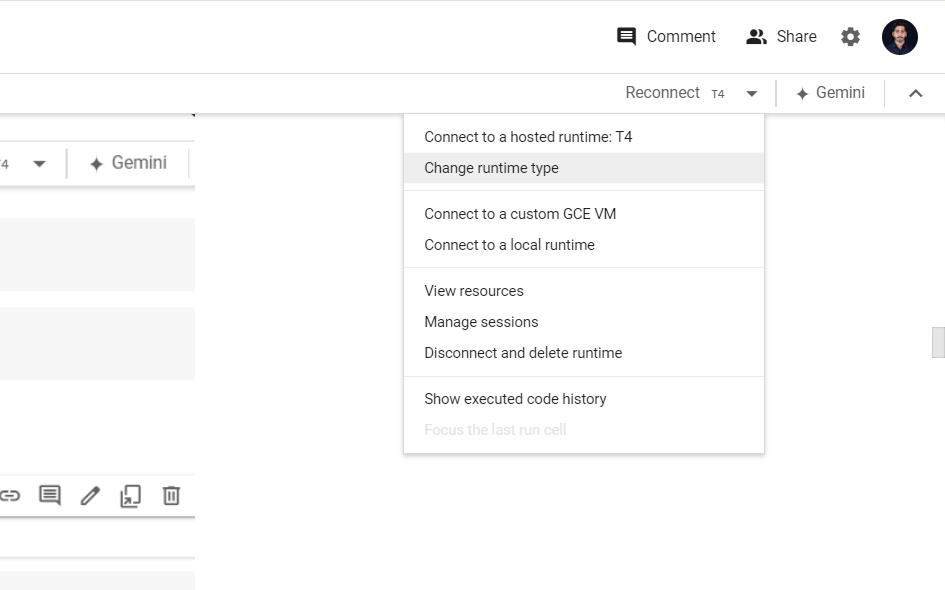**

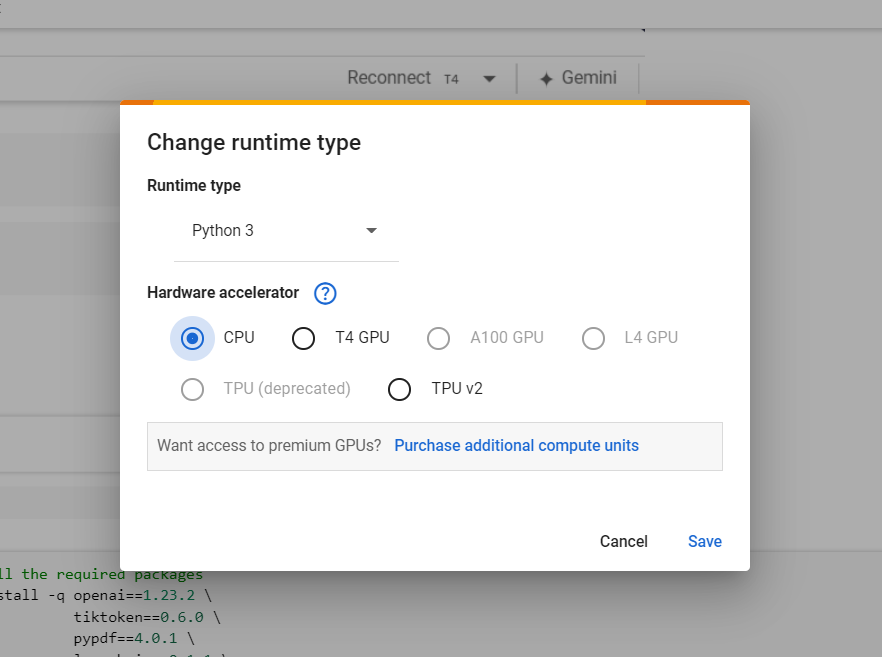

In [1]:
# Install the required packages
!pip install -q openai==1.23.2 \
                tiktoken==0.6.0 \
                pypdf==4.0.1 \
                langchain==0.1.1 \
                langchain-community==0.0.13 \
                chromadb==0.4.22 \
                sentence-transformers==2.3.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.0/284.0 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.4/802.4 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.0/509.0 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 273.8/273.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.0/94.0 kB 4.8 MB/s eta 

In [2]:
# Import the necessary Libraries
import json
import tiktoken

import pandas as pd
from openai import AzureOpenAI

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFDirectoryLoader

from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings
)
from langchain_community.vectorstores import Chroma

from google.colab import userdata, drive

## Authentication

Let's set up our Azure OpenAI credential so that we can access openAI models for our RAG application.

In [4]:
with open('config.json', 'r') as az_creds:
    data = az_creds.read()

In [5]:
creds = json.loads(data)

In [14]:
client = AzureOpenAI(
    azure_endpoint=creds["AZURE_OPENAI_ENDPOINT"],
    api_key=creds["AZURE_OPENAI_KEY"],
    api_version=creds["AZURE_OPENAI_APIVERSION"]
)

In [15]:
deployment_name = creds["CHATGPT_MODEL"]
print(deployment_name)

msft-June2024


In [16]:
response = client.embeddings.create(
    input = "Your text string goes here",
    model= "embed_v01"
)

In [17]:
print(response.model_dump_json(indent=2))

{
  "data": [
    {
      "embedding": [
        -0.007578954566270113,
        -0.0055061643943190575,
        0.011402026750147343,
        -0.0247525442391634,
        -0.024873483926057816,
        0.039802949875593185,
        -0.010347154922783375,
        -0.009480412118136883,
        -0.013384111225605011,
        -0.00991042423993349,
        -0.011717816814780235,
        0.008217253722250462,
        -0.014338199980556965,
        0.0077603659592568874,
        0.010044802911579609,
        -0.0049820877611637115,
        0.022777177393436432,
        -0.0017082883277907968,
        0.015319163911044598,
        -0.010279965586960316,
        0.0049182577058672905,
        0.012208298780024052,
        0.004834271036088467,
        0.010568879544734955,
        -0.006574474740773439,
        -0.00044596908264793456,
        0.005707732401788235,
        -0.012853316031396389,
        0.01634044200181961,
        0.004454651847481728,
        0.0063762660138309,
        -0.0

In [18]:
r=response.model_dump_json()

In [19]:
embeddings = response.data[0].embedding
print(len(embeddings))

1536


## Mount Google Drive

In [20]:
#Mount the Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Vector DB from Google Drive

In [21]:
# Initialise the embedding model
embedding_model = SentenceTransformerEmbeddings(model_name='thenlper/gte-large')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [22]:
# Load the persisted DB
persisted_vectordb_location = '/content/drive/MyDrive/reports_db'

In [23]:
#Create a Colelction Name
collection_name = 'reports_collection'

In [24]:
# Load the persisted DB
reports_db = Chroma(
    collection_name=collection_name,
    persist_directory=persisted_vectordb_location,
    embedding_function=embedding_model
)

Let's test our database with a sample question.

Say, the financial markets are responding positively to AI, then we would like to know which companies have aggresively integrated AI in their business units.

In [25]:
user_question = "How is the company integrating AI across their various business units"

In [26]:
# Perform similarity search on the user_question
# You must add an extra parameter to the similarity search  function so that you can filter the response based on the 'source'  in the metadata of the doc
# The filter can be added as a parameter to the similarity search function
# This will allow you to retrieve chunks from a particular document
# Use the same format to filter your response based on the company.
docs = reports_db.similarity_search(user_question, k=5, filter = {"source":"dataset/Meta-10-k-2023.pdf"})

In [27]:
# Print the retrieved docs, their source and the page number
# (page number can be accessed using doc.metadata['page'] )
for i, doc in enumerate(docs):
    print(f"Retrieved chunk {i+1}: \n")
    print(doc)
    print(doc.page_content.replace('\t', ' '))
    print("Source: ", doc.metadata['source'],"\n ")
    print("Page Number: ",doc.metadata['page'],"\n===================================================== \n")
    print('\n')

Retrieved chunk 1: 

page_content="Further, we face significant competition from other companies that are developing their own AI features and technologies. Other companies may\ndevelop AI features and technologies that are similar or superior to our technologies or are more cost-effective to develop and deploy. Given the long history of\ndevelopment in the AI sector, other parties may have (or in the future may obtain) patents or other proprietary rights that would prevent, limit, or interfere with\nour ability to make, use, or sell our own AI features. Further, our ability to continue to develop and effectively deploy AI technologies is dependent on access to\nspecific third-party equipment and other physical infrastructure, such as processing hardware and network capacity, as to which we cannot control the\navailability or pricing, especially in a highly competitive environment.\nWe are also developing AI technology that we make available via open source, commercial, and non-commerc

In [28]:
# Perform similarity search on the user_question
# You must add an extra parameter to the similarity search  function so that you can filter the response based on the 'source'  in the metadata of the doc
# The filter can be added as a parameter to the similarity search function
# This will allow you to retrieve chunks from a particular document
# Use the same format to filter your response based on the company.
docs = reports_db.similarity_search(user_question, k=5)

In [29]:
# Print the retrieved docs, their source and the page number
# (page number can be accessed using doc.metadata['page'] )
for i, doc in enumerate(docs):
    print(f"Retrieved chunk {i+1}: \n")
    print(doc)
    print(doc.page_content.replace('\t', ' '))
    print("Source: ", doc.metadata['source'],"\n ")
    print("Page Number: ",doc.metadata['page'],"\n===================================================== \n")
    print('\n')

Retrieved chunk 1: 

page_content='it can generalize and seamlessly understand, operate across, and combine different types of information, including \ntext, code, audio, images, and video. Our teams across Alphabet will leverage Gemini, as well as other AI models we \nhave previously developed and announced, across our business to deliver the best product and service experience s \nfor our use rs, advertisers, partners, customers, and developers.\nWe believe our approach to AI must be both bold and responsible. That means developing AI in a way that \nmaximizes the positive benefits to society while addressing the challenges, guided by our AI P rinciples.  We published \nthese in 2018, as one of the first companies to articulate principles that put beneficial use, users, safety, and avoidance \nof harms above business considerations. While there is natural tension between being bold and being responsible, we \nbelieve it is possible — and in fact critical — to embrace that tension pro

## RAG Q&A

### Prompt Design

In [35]:
# Create a system message for the LLM
qna_system_message = """
You are an assistant to a Financial Analyst. Your task is to summarize and provide relevant information to the financial analyst's question based on the provided context.

User input will include the necessary context for you to answer their questions. This context will begin with the token: ###Context.
The context contains references to specific portions of documents relevant to the user's query, along with page number from the report.
The source for the context will begin with the token ###Page

When crafting your response:
1. Select only context relevant to answer the question.
2. Include the source links in your response.
3. User questions will begin with the token: ###Question.
4. If the context is irrelevant or if the context is empty - "Sorry, this is out of my knowledge base"

Please adhere to the following guidelines:
- Your response should only be about the question asked and nothing else.
- Answer only using the context provided.
- Do not mention anything about the context in your final answer.
- If the answer is not found in the context, it is very very important for you to respond with "Sorry, this is out of my knowledge base"
- If NO CONTEXT is provided, it is very important for you to respond with "Sorry, this is out of my knowledge base"

Here is an example of how to structure your response:

Answer:
[Answer]

Page:
[Page number]
"""

In [36]:
# Create a message template
qna_user_message_template = """
###Context
Here are some documents and their page number that are relevant to the question mentioned below.
{context}

###Question
{question}
"""

### Composing the response

In [32]:
# Create a variable company to store the source of the context so that you can filter the similarity search
company = "dataset/google-10-k-2023.pdf" # We shall change this programmatically later when we test on multiple queries for each of the company

In [33]:
# Create context for query by joining page_content and page number of the retrieved docs
relevant_document_chunks = reports_db.similarity_search(user_question, k=5, filter = {"source": company} )

context_list = [d.page_content + "\n ###Page: " + str(d.metadata['page']) + "\n\n " for d in relevant_document_chunks]

context_for_query = ". ".join(context_list)

print(context_for_query) # Print the whole context_for_query (after joining all the chunks. It should contain page number of every chunk)


it can generalize and seamlessly understand, operate across, and combine different types of information, including 
text, code, audio, images, and video. Our teams across Alphabet will leverage Gemini, as well as other AI models we 
have previously developed and announced, across our business to deliver the best product and service experience s 
for our use rs, advertisers, partners, customers, and developers.
We believe our approach to AI must be both bold and responsible. That means developing AI in a way that 
maximizes the positive benefits to society while addressing the challenges, guided by our AI P rinciples.  We published 
these in 2018, as one of the first companies to articulate principles that put beneficial use, users, safety, and avoidance 
of harms above business considerations. While there is natural tension between being bold and being responsible, we 
believe it is possible — and in fact critical — to embrace that tension productively.
Enable Organizations and Develop

In [37]:
# Craft the messages to pass to chat.completions.create
prompt = [
    {'role':'system', 'content': qna_system_message},
    {'role': 'user', 'content': qna_user_message_template.format(
         context=context_for_query,
         question=user_question
        )
    }
]

In [ ]:
prompt

[{'role': 'system',
  'content': '\nYou are an assistant to a Financial Analyst. Your task is to summarize and provide relevant information to the financial analyst\'s question based on the provided context.\n\nUser input will include the necessary context for you to answer their questions. This context will begin with the token: ###Context.\nThe context contains references to specific portions of documents relevant to the user\'s query, along with page number from the report.\nThe source for the context will begin with the token ###Page\n\nWhen crafting your response:\n1. Select only context relevant to answer the question.\n2. Include the source links in your response.\n3. User questions will begin with the token: ###Question.\n4. If the context is irrelevant or if the context is empty - "Sorry, this is out of my knowledge base"\n\nPlease adhere to the following guidelines:\n- Your response should only be about the question asked and nothing else.\n- Answer only using the context pro

In [38]:
# Get a response from the LLM
# Handle errors using try-except
try:
    response = client.chat.completions.create(
        model=deployment_name,
        messages=prompt,
        temperature=0
    )

    prediction = response.choices[0].message.content.strip()
except Exception as e:
    prediction = f'Sorry, I encountered the following error: \n {e}'

print(prediction)

The company is expanding its investment in AI across the entire company, including generative AI and continuing to integrate AI capabilities into its products and services. AI technology and services are highly competitive, rapidly evolving, and require significant investment, including development and operational costs, to meet the changing needs and expectations of its existing users and attract new users. Its Vertex AI platform gives developers the ability to train, tune, augment, and deploy applications using generative AI models and services such as Enterprise Search and Conversations. Duet AI for Google Cloud provides pre-packaged AI agents that assist developers to write, test, document, and operate software. Duet AI in Google Workspace helps users write, organize, visualize, accelerate workflows, and have richer meetings.

Page: 5, 11


## Evaluation

It is important to note that all the answers may not be found in the documents provided to the RAG system. The RAG system can be augmented with further information like new and legitimate sources from internet. In any case, when the information is not available to the RAG system, we want it to state the same instead of 'halucinating' information which can lead to very bad consequences. Hence, we need to evaluate the RAG not only on how well it answers a question (relevance) but also on how much of the answer comes from the context provided (Groundedness).

In [42]:
# Create a prompt for the rater LLM to check the groundedness of the response
groundedness_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context and includes ###Page while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
The answer should be derived only from the information presented in the context.

Instructions:
1. Check if the context provided has the necessary information required to answer the question provided.
2. If the context provided doesn't have the necessary information to answer the question, then the answer should be "Sorry, this is out of my knowledge base". If that is the case, then award a full rating of 5. But if the model answers with information that is not present in the context, then rate the model low.
3. If the context provides necessary information, then check the answer and rate how well the model captures the context and answers the question using the evaluation criteria mentioned above.
4. If the model includes information that is not provided in the context, then the rating should be low - proportional to the amount of information provided that is not in the context.
"""

In [43]:
# Create a prompt for the rater LLM to check the relevance of the response
relevance_rater_system_message = """
You are tasked with rating AI generated answers to questions posed by users.
You will be presented a question, context used by the AI system to generate the answer and an AI generated answer to the question.
In the input, the question will begin with ###Question, the context will begin with ###Context while the AI generated answer will begin with ###Answer.

Evaluation criteria:
The task is to judge the extent to which the metric is followed by the answer.
1 - The metric is not followed at all
2 - The metric is followed only to a limited extent
3 - The metric is followed to a good extent
4 - The metric is followed mostly
5 - The metric is followed completely

Metric:
Relevance measures how well the answer addresses the main aspects of the question, based on the context.
Consider whether all and only the important aspects are contained in the answer when evaluating relevance.

Instructions:
1. Check if the answer is "Sorry, this is out of my knowledge base", if so rate the model 5.
2. Else, check the answer against the question and see how well the answer answers the provided question.
3. Use the above evaluation criteria to then rate the answer based on how well the model
"""

In [44]:
#Create user message template such that question, answer and context can be provided through it.
user_message_template = """
###Question
{question}

###Context
{context}

###Answer
{answer}
"""

Let's manually check our RAG and evaluate its responses on a sample question

To evaluate the company's investment strategy, it is essential to identify whether it aligns with current market trends or is directed towards sectors experiencing significant downturns. This analysis will enable financial analysts to make informed decisions.

For instance, if the cryptocurrency sector is facing technological challenges and consequently has a negative market sentiment, companies with substantial investments in this area are likely to experience adverse effects as well. Understanding these dynamics will provide valuable insights into the potential risks and opportunities associated with the company's investment choices.

In [45]:
user_input = "How much is the company investing in research and development, and what are the key areas of focus for innovation?"

In [46]:
# Create context
relevant_document_chunks = reports_db.similarity_search(user_question, k=5, filter = {"source": company} )
context_list = [d.page_content + "\n ###Page: " + str(d.metadata['page']) + "\n\n " for d in relevant_document_chunks]
context_for_query = ". ".join(context_list)

In [47]:
# Create the messages for chat.completion.create()
prompt = [
    {'role':'system', 'content': qna_system_message},
    {'role': 'user', 'content': qna_user_message_template.format(
         context=context_for_query,
         question=user_input
        )
    }
]


In [48]:
# Get a response from the LLM
# Handle errors using try-except
try:
    response = client.chat.completions.create(
        model=deployment_name,
        messages=prompt,
        temperature=0
    )

    answer = response.choices[0].message.content.strip()
except Exception as e:
    answer = f'Sorry, I encountered the following error: \n {e}'

print(answer)

Our businesses face changing technologies, shifting user needs, and frequent introductions of rival products and services. To compete successfully, we must accurately anticipate technology developments and deliver innovative, relevant and useful products, services, and technologies in a timely manner. As our businesses evolve, the competitive pressure to innovate will encompass a wider range of products and services. We must continue to invest significant resources in technical infrastructure and R&D, including through acquisitions, in order to enhance our technology, products, and services. We are expanding our investment in AI across the entire company. This includes generative AI and continuing to integrate AI capabilities into our products and services. AI technology and services are highly competitive, rapidly evolving, and require significant investment, including development and operational costs, to meet the changing needs and expectations of our existing users and attract new 

We can see that this company is not majorly investing in crypto.

In [49]:
# Create messages for groundness
groundedness_prompt = [
    {'role':'system', 'content': groundedness_rater_system_message},
    {'role': 'user', 'content': user_message_template.format(
        question=user_input,
        context=context_for_query,
        answer=answer
        )
    }
]

In [50]:
# Print the response of the rater LLM on groundedness
response = client.chat.completions.create(
    model=deployment_name,
    messages=groundedness_prompt,
    temperature=0
)

print(response.choices[0].message.content)

The answer provided does not directly address the question asked about the amount of investment in research and development and the key areas of focus for innovation. However, the context mentions that the company must continue to invest significant resources in technical infrastructure and R&D, including through acquisitions, in order to enhance their technology, products, and services. It also mentions that the company is expanding its investment in AI across the entire company, including generative AI and continuing to integrate AI capabilities into their products and services. Therefore, the answer partially addresses the question and follows the metric to a limited extent. The rating is 2.


In [51]:
# Print the response of the rater LLM on relevance

relevance_prompt = [
    {'role':'system', 'content': relevance_rater_system_message},
    {'role': 'user', 'content': user_message_template.format(
        question=user_input,
        context=context_for_query,
        answer=answer
        )
    }
]

In [52]:
# Print the response of the rater LLM on relevance
response = client.chat.completions.create(
    model=deployment_name,
    messages=relevance_prompt,
    temperature=0
)

print(response.choices[0].message.content)

The answer provides information about the company's investment in research and development, as well as its focus on innovation in AI. It also mentions the need to invest in technical infrastructure and R&D to enhance their technology, products, and services. However, the answer does not directly address the question of how much the company is investing in research and development, nor does it provide specific information about the key areas of focus for innovation. Therefore, the answer is only following the metric to a limited extent. I rate it 2.


### Evaluation on multiple queries

In [53]:
# List of queries
queries = [ "What initiatives has the company implemented to address ethical concerns surrounding AI, such as fairness, accountability, and privacy?",
           "How does the company plan to differentiate itself in the AI space relative to competitors?",
"Has the company made any significant acquisitions in the AI space, and how are these acquisitions being integrated into the company's strategy?"

]
# Create a DataFrame to store the results
df = pd.DataFrame(columns=['query', 'company','response', 'context', 'groundedness_evaluation', 'relevance_evaluation'])

# run a loop to get answer for every query and every company and then rate them on groundedness and relevance
# store the query, response, context,groundedness_evaluation, relevance_evaluation in a dataframe
for query in queries:


    for company in ["aws","google","IBM","msft","Meta"]:
      company = "dataset/"+company+"-10-k-2023.pdf"
      relevant_document_chunks = reports_db.similarity_search(user_question, k=5, filter = {"source": company} )
      context_list = [d.page_content + "\n ###Page: " + str(d.metadata['page']) + "\n\n " for d in relevant_document_chunks]
      context_for_query = ". ".join(context_list)

      prompt = [
          {'role':'system', 'content': qna_system_message},
          {'role': 'user', 'content': qna_user_message_template.format(
              context=context_for_query,
              question=query
              )
          }
      ]


      response = client.chat.completions.create(
          model=deployment_name,
          messages=prompt,
          temperature=0
      )

      answer = response.choices[0].message.content.strip()
      # print(context_for_query)
      # print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
      # print(answer)
      # print("====================================================================")

      # Groundedness prompt
      groundedness_prompt = [
          {'role':'system', 'content': groundedness_rater_system_message},
          {'role': 'user', 'content': user_message_template.format(
              question=query,
              context=context_for_query,
              answer=answer
              )
          }
      ]

      # Get the groundedness response
      response = client.chat.completions.create(
          model=deployment_name,
          messages=groundedness_prompt,
          temperature=0
      )
      groundedness_response = response.choices[0].message.content

      # Relevance prompt
      relevance_prompt = [
          {'role':'system', 'content': relevance_rater_system_message},
          {'role': 'user', 'content': user_message_template.format(
              question=query,
              context=context_for_query,
              answer=answer
              )
          }
      ]

      # Get the relevance response
      response = client.chat.completions.create(
          model=deployment_name,
          messages=relevance_prompt,
          temperature=0
      )
      relevance_response = response.choices[0].message.content

      # Store the query and responses in the DataFrame
      df = pd.concat([df, pd.DataFrame([{'query': query, 'company':company,'response': answer, 'context': context_for_query, 'groundedness_evaluation': groundedness_response, 'relevance_evaluation': relevance_response}])], ignore_index=True)


In [ ]:
pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.max_colwidth', 300)

In [ ]:
# show the top 10 rows of the dataframe
df.head(10)

In [ ]:
df.response[1]

Check the different groundedness scores and relevance scores obtained for our questions across different companies. As you can see when there is no relevant context provided, the model responds most of the time with "Sorry, this is out of my knowledge base" and when the context is provided, it responds with a decent answer.

For Example, we asked the question - "What initiatives has the company implemented to address ethical concerns surrounding AI, such as fairness, accountability, and privacy?
" w.r.t google and the model summarises the context provided to it and answer the question by talking about how google prioritises beneficial use, users safty and avoidance of harms above business consideration.

While the same question asked to msft, the model emphasises microsofts philosophy of getting AI to everyone but by keeping ethics, and fairness at the forefront.

And the the same question to aws return nothing showing the lack of strong ethical guideliness/principles assumed by amazon regarding AI. This could be an important insight.

Identifying such differences can enable financial analysts to make prudent decisions. For example, if the government introduces new regulations requiring companies developing AI solutions to adhere to a specific set of ethical standards, this could influence the stock performance of these companies based on their compliance with these ethical commitments.

Overall our model does a good job of providing relevant information while being grounded in the information provided.

## Power Ahead!